In [1]:
import autograd.numpy as np 
from autograd import grad, elementwise_grad, jacobian, make_jvp , holomorphic_grad
from autograd.extend import primitive, defvjp, defjvp
from autograd.scipy.special import erf

import GPy
from GPy.kern import Kern
from GPy.core.parameterization.param import Param

import matplotlib.pyplot as plt
import scipy
from scipy.special import wofz

## Adding Fadeeva to Autograd

In [2]:
inv_root_pi = 0.56418958354775627928

 
wofz =  primitive(scipy.special.wofz)
defvjp(wofz, lambda ans, x: lambda g:  g * ( -2 * x * wofz(x) + 2.0j * inv_root_pi ) )

### Manual Gradient Check

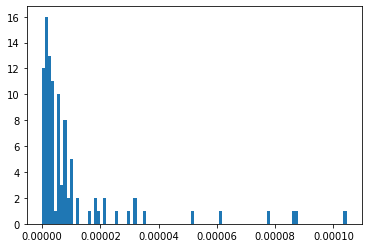

In [90]:
# Autograd cant differentiate complex output functions properly 
# thus checking for values of w(iz) that are real namely w(ix) for real x

epsilon = 1e-12
    
x =  np.array([8j]) #  
x  = 1j *  np.linspace(0,30, 100)

finite = (wofz( x) - wofz((x- 1j * epsilon) ) ) / epsilon
finite = np.real(finite)

wofz_r = lambda x: np.real(wofz( x))
auto_grad = grad(wofz_r)
auto_eval = 1j * np.array([auto_grad(xi) for xi in x])

err = np.abs( finite - auto_eval )

plt.hist(err, bins=100);
     
    

In [95]:
# Complex check

x = 8j  + 1

epsilon = 1e-10
print( (wofz(x) - wofz((x- 1j * epsilon) ) ) / epsilon )


print( 1j* (-2 * x * wofz(x) + 2.0j * inv_root_pi ) )

(-0.008242295734817162-0.0020459328675670463j)
(-0.008242177574274479-0.0020459055037121976j)


# Vectorized  kernel

In [333]:
def vec_digamma_like_q(t1, t2, γd, lq):
    
    t1Minust2 = t1[...,None] - t2
    zdt1 = (t1Minust2) / lq - 0.5 * lq * γd
    zd0 = (-t2[None, ...] ) / lq - 0.5 * lq * γd
    
    term1 = 2 * np.exp( 0.25 * (lq * γd)**2 - (t1Minust2) * γd )
    term2 = np.exp(-(t1Minust2)**2 / lq**2)  * wofz(1.0j * zdt1)
    term3 = np.exp(-(t2[None,...])**2 / lq**2) * np.exp(-t1[..., None] * γd) * wofz(-1.0j * zd0)

    return (term1 - term2 - term3).T


def vec_h_q(t1, t2, γd1, γd2, lq):
#     print(t1.shape, t2.shape, γd1, γd2, lq.shape)
    kek = np.exp(-γd2 * t1[...,None]) * vec_digamma_like_q(t2, np.array([0]), γd2, lq) 
    
    num = vec_digamma_like_q(t2, t1, γd1, lq)- np.exp(-γd2 * t1[...,None]) * vec_digamma_like_q(t2, np.array([0]), γd1, lq) 

    denom = γd1 + γd2
    zdt1 = (t1[...,None] - t2) / lq - 0.5 * lq * γd2
    sauce = - np.real(np.exp(-γd2 * t1[...,None]) * vec_digamma_like_q(t2, np.array([0]), γd1, lq) )
    

    return num / denom



def k_q(t1, t2, lq, Bd1, Cd1, Md1, Sqd1, Bd2, Cd2, Md2, Sqd2 , h_q=vec_h_q):
    α_d1 = 0.5 * Cd1
    ω_d1 = 0.5 * np.sqrt(4 * Bd1 - Cd1**2)
    
    α_d2 = 0.5 * Cd2
    ω_d2 = 0.5 * np.sqrt(4 * Bd2 - Cd2**2)
    
    γd1 = α_d1 + 1.0j * ω_d1
    tγd1 = α_d1 - 1.0j * ω_d1
    
    γd2 = α_d2 + 1.0j * ω_d2
    tγd2 = α_d2 - 1.0j * ω_d2
    
    K_qd = lq  * np.sqrt(np.pi) / (8.0 * ω_d2 * ω_d1)
    
    
    
    h_tγd2_γd1_t1_t2 = h_q(t1, t2, tγd2, γd1, lq)
    h_γd1_tγd2_t2_t1 = h_q(t2, t1, γd1, tγd2, lq).T
    h_γd2_tγd1_t1_t2 = h_q(t1, t2, γd2, tγd1, lq)
    h_tγd1_γd2_t2_t1 = h_q(t2, t1, tγd1, γd2, lq).T
    
    
#     import pdb; pdb.set_trace()
#     
    h_tγd2_tγd1_t1_t2 = h_q(t1, t2, tγd2, tγd1, lq)
    h_tγd1_tγd2_t2_t1 = h_q(t2, t1, tγd1, tγd2, lq).T
    h_γd2_γd1_t1_t2 = h_q(t1, t2, γd2, γd1, lq)
    h_γd1_γd2_t2_t1 = h_q(t2, t1, γd1, γd2, lq).T
    
    
#     plt.imshow(np.real(h_γd1_tγd2_t2_t1))
#     return h_γd1_tγd2_t2_t1
    
    return K_qd * ((h_tγd2_γd1_t1_t2 + h_γd1_tγd2_t2_t1 + h_γd2_tγd1_t1_t2 + h_tγd1_γd2_t2_t1) 
                  -(h_tγd2_tγd1_t1_t2 + h_tγd1_tγd2_t2_t1 + h_γd2_γd1_t1_t2 + h_γd1_γd2_t2_t1)) 


def vec_k_q_test(t1vec, t2vec, lq, Bd1, Cd1, Md1, Sqd1): #, Bd2, Cd2, Md2, Sqd2 ):
    n1 = t1vec.shape[0]
    n2 = t2vec.shape[0]
    out = np.zeros((n1, n2), dtype=np.complex)

    
    tmp = Sqd1 *Sqd1 * k_q(t1vec, t2vec, lq, Bd1, Cd1, Md1, Sqd1, Bd1, Cd1, Md1, Sqd1 , h_q=vec_h_q) 
    out= np.real(tmp)
    return out


def vec_k_q_test_2(t1vec, t2vec, lq, Bd1, Cd1, Md1, Sqd1, Bd2, Cd2, Md2, Sqd2 ):
    n1 = t1vec.shape[0]
    n2 = t2vec.shape[0]
    out = np.zeros((n1, n2), dtype=np.complex)

    
    tmp = Sqd1 *Sqd1 * k_q(t1vec, t2vec, lq, Bd1, Cd1, Md1, Sqd1, Bd2, Cd2, Md2, Sqd2 , h_q=vec_h_q) 
    out= np.real(tmp)
    return out


def k_f(tmat1, tmat2, l_vec, bvec, cvec, m, Smat, debug=False):
    q = l_vec.shape[0]
    n1, d = tmat1.shape
    n2, d = tmat2.shape
    
    kf = np.zeros((n1 * d, n2 * d), dtype=np.complex)
    
    for i_q in range(q):
        l_iq = l_vec[i_q]
        out =  None
        for d1 in range(d):
            for d2 in range(d):
                t1vec = tmat1[:,d1]
                t2vec = tmat2[:,d2]
                
                lq = l_vec[i_q]
                
                Bd1 = bvec[d1]
                Cd1 = cvec[d1]
                Sqd1 = Smat[i_q, d1]
                
                Bd2 = bvec[d2]
                Cd2 = cvec[d2]
                Sqd2 = Smat[i_q, d2]             
                
                cake = Sqd1 * Sqd2 * k_q(t1vec, t2vec, l_iq, Bd1, Cd1, m, Sqd1, Bd2, Cd2, m, Sqd2 , h_q=vec_h_q) 
                print(cake.shape)
                if out is None:
                    out = cake[None, ...]
                else:
                    out = np.concatenate((out, cake[None,...] ), axis=0)

        out = out.reshape(d,d,n1, n2)    
        out = np.transpose(out, (0,2,1,3)).reshape(n1 *d , n2 * d)
        kf += out
#     plt.imshow(np.imag(kf)) 
#     plt.colorbar()
    return np.real(kf)


def grad_kf(tmat1, tmat2, lvec, bvec, cvec, mvec, Smat, debug=False, func=vec_k_q_test):
    
    if func.__name__ == "vec_k_q_test":
        tmat1 = tmat1.flatten()
        tmat2 = tmat2.flatten()
    
    gradient_funcs = [jacobian(func, pi) for pi in (2,3,4,5,6)]
    gradients = [gradient(tmat1,tmat2, lvec, bvec, cvec,  mvec , Smat) for gradient in gradient_funcs]
    if debug:
        for grd in gradients:
            plt.imshow(np.squeeze(grd))
            plt.show()
    return gradients
from copy import deepcopy

def grad_kf_check(tmat1, tmat2, lvec, bvec, cvec, mvec, Smat, epsilon = 0.00001, func=vec_k_q_test, debug=False):
    
    
    if func.__name__ == "vec_k_q_test":
        tmat1 = tmat1.flatten()
        tmat2 = tmat2.flatten()
        
    params = (tmat1,tmat2, lvec, bvec, cvec,  mvec , Smat)
    gradients = []
    for pi in (2,3,4,5,6):
        parep = deepcopy(list(params))
        parep[pi] -= epsilon
        grd = (func(*params) - func(*parep)) / epsilon
        
        gradients.append(grd)
        if debug:
            plt.imshow(grd)
            plt.show()

    return gradients




def k_q_test_diag(t1vec, lq, Bd1, Cd1, Md1, Sqd1 ):
    return np.diag(vec_k_q_test(t1vec, t1vec, lq, Bd1, Cd1, Md1, Sqd1))
    n = t1vec.shape[0]
    out = np.zeros(n, dtype=np.complex)
    for i, t1 in enumerate(t1vec):
        tmp = Sqd1**2 * k_q(t1, t1, lq, Bd1, Cd1, Md1, Sqd1,  Bd1, Cd1, Md1, Sqd1)
        out[i] = tmp
    return out


debug_multioutput = False


if debug_multioutput:

    d = 2
    n=20

    bvec_ = np.array([b, 0.5 * b])
    cvec_ = np.array([c, c])
    Smat_ = np.array([[s*2, s]])
    lvec_ = np.array([l])

    t12 = np.linspace(0,5, n).repeat(d).reshape(n,d) + 20
    kk3 = k_f(t12, t12, lvec_, bvec_, cvec_, 1, Smat_, debug=False)

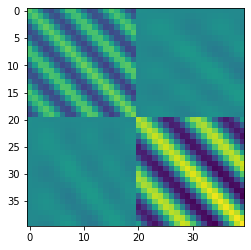

In [297]:
plt.imshow(kk3)

In [278]:
%matplotlib inline

In [298]:
t1vec = np.linspace(0,5, 20) +  50

l = 1.0
b = 10.0# 3.5
c = 0.001 #0.5
s = 2.0
kk2 = vec_k_q_test(t1vec, t1vec, l, b, c, 1, s)#, b, c, 1, s )

print(kk2.shape)
print(c /(2 * np.sqrt(b)))
print(np.abs(np.imag(kk2)).max())
print(np.abs(np.real(kk2 - kk2.T)).max())

(20, 20)
0.00015811388300841897
0.0
2.6645352591003757e-15


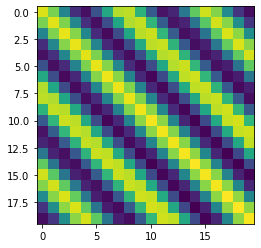

In [299]:
plt.imshow(kk2)

In [300]:
tmat1 =  t1vec.reshape(-1,1)
bvec = np.array([b])
cvec = np.array([c])
Smat = np.array([[s]])
lvec = np.array([[l]])

kk3 = k_f(tmat1, tmat1, lvec, bvec, cvec, 1, Smat, debug=False)

(20, 20)


In [301]:
np.abs(kk2 - kk3).max()

0.0

In [302]:
grademp = grad_kf_check(t1vec, t1vec, l, b, c, 1, s,epsilon = 1e-10, debug=False);

False
(20, 20)
(20, 20)
1e-06
(array([[1.]]), array([10.]), array([0.001]), 1, array([[2.]]))
[array([[0.999999]]), array([10.]), array([0.001]), 1, array([[2.]])]
False


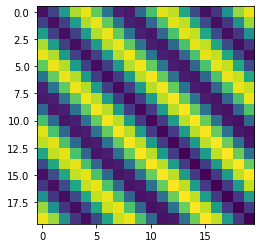

False
(20, 20)
(20, 20)
1e-06
(array([[1.]]), array([10.]), array([0.001]), 1, array([[2.]]))
[array([[1.]]), array([9.999999]), array([0.001]), 1, array([[2.]])]
False


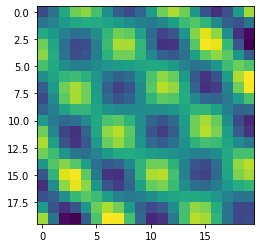

False
(20, 20)
(20, 20)
1e-06
(array([[1.]]), array([10.]), array([0.001]), 1, array([[2.]]))
[array([[1.]]), array([10.]), array([0.000999]), 1, array([[2.]])]
False


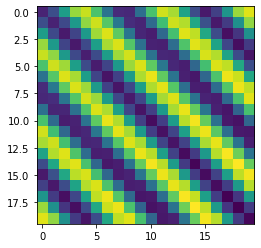

False
(20, 20)
(20, 20)
1e-06
(array([[1.]]), array([10.]), array([0.001]), 1, array([[2.]]))
[array([[1.]]), array([10.]), array([0.001]), 0.999999, array([[2.]])]
False


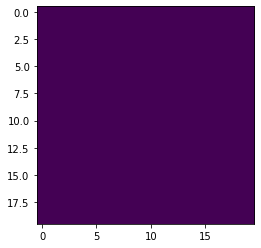

False
(20, 20)
(20, 20)
1e-06
(array([[1.]]), array([10.]), array([0.001]), 1, array([[2.]]))
[array([[1.]]), array([10.]), array([0.001]), 1, array([[1.999999]])]
False


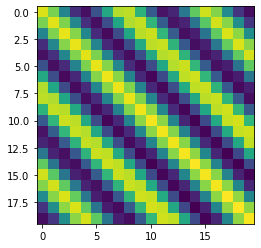

In [334]:
tmat1 =  t1vec.reshape(-1,1)
bvec = np.array([b])
cvec = np.array([c])
Smat = np.array([[s]])
lvec = np.array([[l]])

grademp_ = grad_kf_check(tmat1, tmat1, lvec, bvec, cvec, 1, Smat,epsilon = 1e-6 , func =k_f, debug=True);

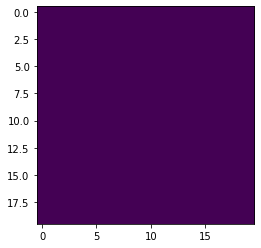

In [311]:
plt.imshow(grademp_[2])

(20, 20)
(20, 20)


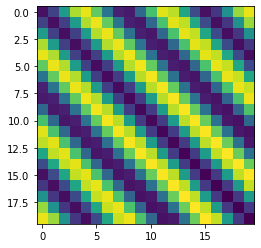

In [316]:
epsilon = 1e-10

delta = k_f(tmat1, tmat1, lvec, bvec, cvec, 1, Smat, debug=False) - k_f(tmat1, tmat1, lvec-epsilon, bvec, cvec, 1, Smat, debug=False)

plt.imshow(delta/epsilon)

In [305]:
gradauto_orig = grad_kf(t1vec, t1vec, np.array([l]), np.array([b]), np.array([c]), np.array([1]), np.array([s]), debug=False);

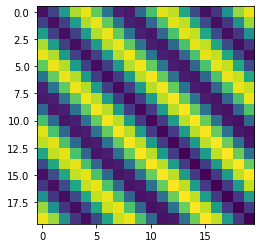

In [306]:
plt.imshow(np.squeeze(gradauto_orig[0]));

In [307]:
gradauto = grad_kf(tmat1, tmat1, lvec, bvec, cvec, np.array([1]), Smat, debug=False, func=k_f);

(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)


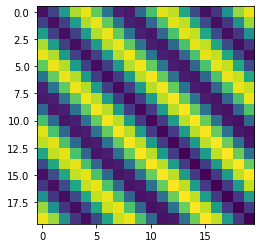

In [308]:
plt.imshow(np.squeeze(gradauto[0]))

In [336]:
[np.abs(np.squeeze(gradauto[fg]) - grademp_[fg]).max() for fg in range(len(gradauto))]

[7.5569010906662015e-06,
 3.973742784602052e-06,
 0.0008285737353475042,
 0.0,
 4.1708015330321757e-07]

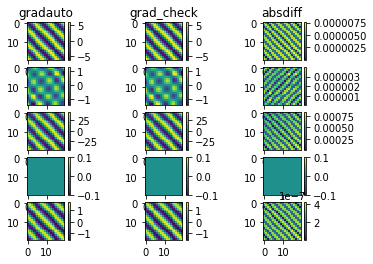

In [687]:
%matplotlib qt
grademp = grademp_ 
from mpl_toolkits.axes_grid1 import make_axes_locatable

paramsters =  "l", "b", "c", "m", "s"
fig, axs = plt.subplots(5, 3)



for i in range(len(gradauto)):
    if i == 0:
        axs[i, 0].set_title("gradauto")
        axs[i, 1].set_title("grad_check")
        axs[i, 2].set_title("absdiff")
        
    divider = make_axes_locatable(axs[i, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = axs[i, 0].imshow(np.squeeze(gradauto[i]))
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    divider = make_axes_locatable(axs[i, 1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = axs[i, 1].imshow(np.squeeze(grademp[i]))
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    im = axs[i, 2].imshow( np.abs( np.squeeze(grademp[i]) - np.squeeze(gradauto[i]) ) )
    divider = make_axes_locatable(axs[i, 2])
    
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


    

## GPy kernel

In [271]:
class LFM2(GPy.kern.Kern):
    
    def __init__(self,input_dim, bvec=np.array([1.0]),
                 lengthscales=np.array([1.0]),
                 Cvec=np.array([1.0]),
                 Smat=np.array([[1.0]]),
                 active_dims=None, debug=False):
    
        super(LFM2, self).__init__(input_dim, active_dims, 'LFM2')
        
        assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.bvec = Param('bvec', bvec)
        self.lengthscales = Param('lengthscales', lengthscales)
        self.Smat = Param('Smat', Smat)
        self.Cvec = Param('Cvec', Cvec)
        self.link_parameters(self.bvec, self.lengthscales, self.Smat, self.Cvec)
        self.show = False
        self.debug = debug
    
    def K(self,X,X2):
        if X2 is None: X2 = X
            
        Bd1 = self.bvec
        Cd1 = self.Cvec
        Sqd1 = self.Smat
        lq = self.lengthscales
        k = k_f(X, X2, lq, Bd1, Cd1, 1.0, Sqd1)

        return np.real(k)
    
    def Kdiag(self, X):
        Bd1 = self.bvec[0]
        Cd1 = self.Cvec[0]
        Sqd1 = self.Smat[0,0]
        lq = self.lengthscales[0]
        return np.diag(self.K(X,X))
    
    def update_gradients_full(self, dL_dK, X, X2):
#         return None
        if X2 is None: X2 = X
#         import pdb; pdb.set_trace
        # (1, 10, 0.001, 1, 1)
#         print(self.lengthscales.values, self.bvec.values, self.Cvec.values, np.array([1.0]), self.Smat.values)
        gradients = grad_kf(X, X2, self.lengthscales.values, self.bvec.values, 
                             self.Cvec.values, np.array([1.0]), self.Smat.values, debug=False, func=k_f)
        
        
        dl = gradients[0]
        db = gradients[1]
        dC = gradients[2]
        dS = gradients[4]
        
        if self.debug:
            fig, axs= plt.subplots(1,4)
            axs[0].imshow(np.squeeze(dl))
            axs[1].imshow(np.squeeze(db))
            axs[2].imshow(np.squeeze(dC))
            axs[3].imshow(np.squeeze(dS))
            plt.show()
        

        self.bvec.gradient = np.sum(db * dL_dK[..., None], axis=(0,1))
        self.lengthscales.gradient =  np.sum(dl * dL_dK[..., None], axis=(0,1))
        self.Cvec.gradient =  np.sum(np.squeeze(dC)[...,None] * dL_dK[..., None], axis=(0,1))
        self.Smat.gradient =  np.sum(dS * dL_dK[..., None, None], axis=(0,1))
        
        

why


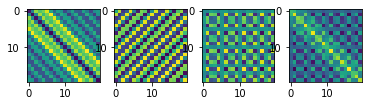

regression


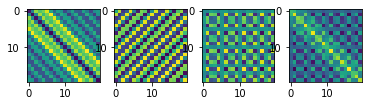

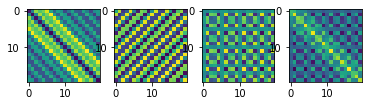

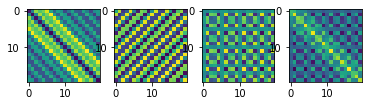

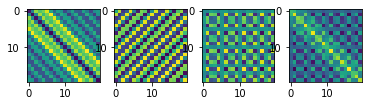

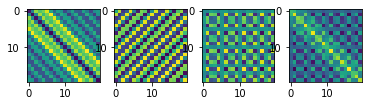

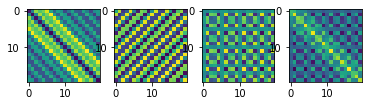

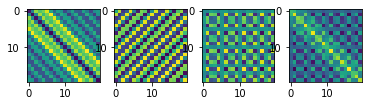

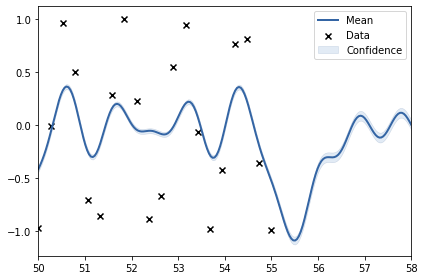

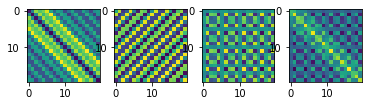

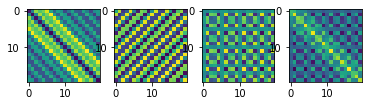

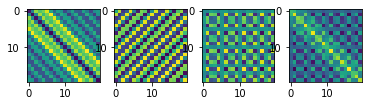

 C:\Users\User\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning:invalid value encountered in sqrt
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:overflow encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:divide by zero encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:overflow encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:divide by zero encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning:overflow encountered in true_divide
 C:\Users\User\Anaconda3\lib\

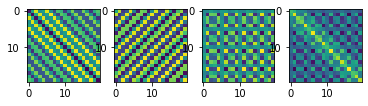

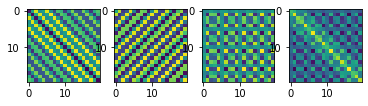

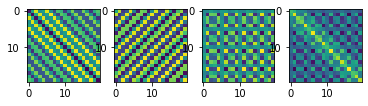

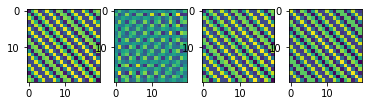

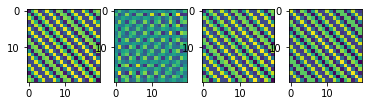

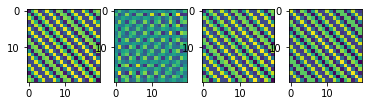

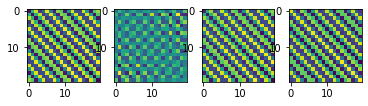

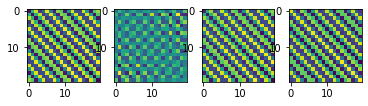

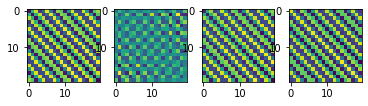

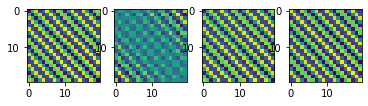

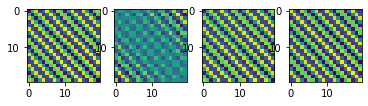

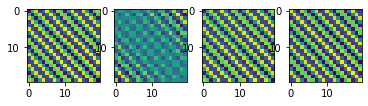

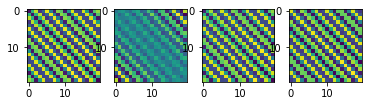

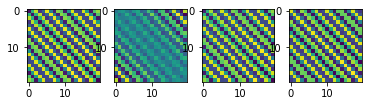

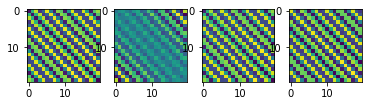

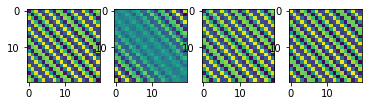

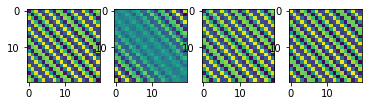

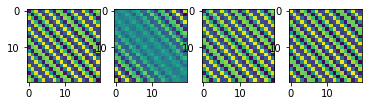

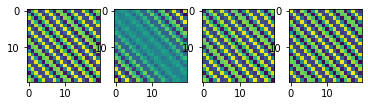

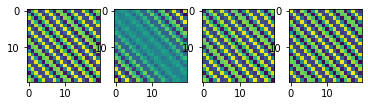

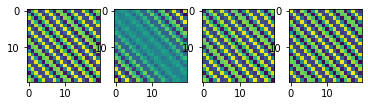

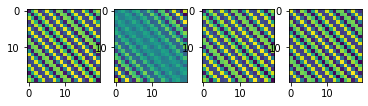

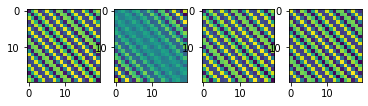

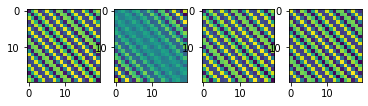

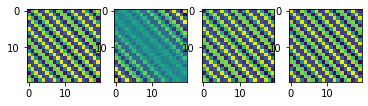

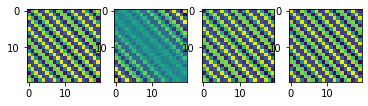

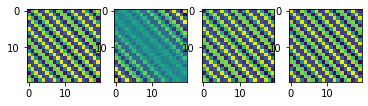

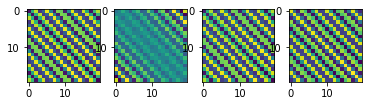

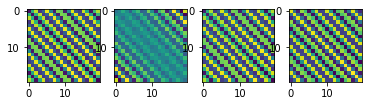

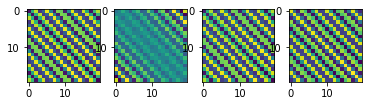

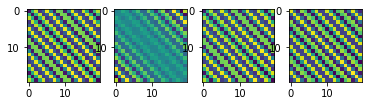

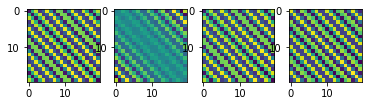

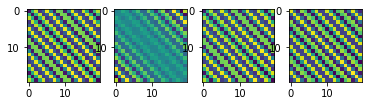

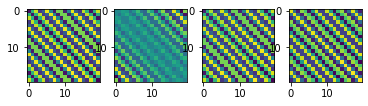

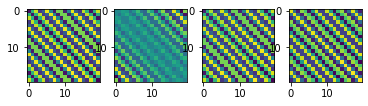

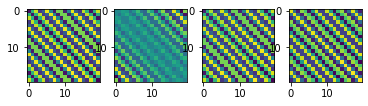

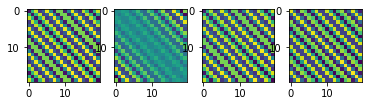

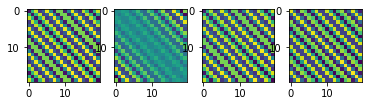

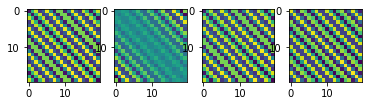

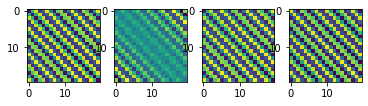

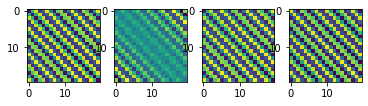

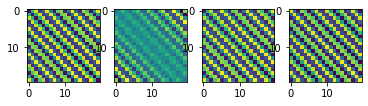

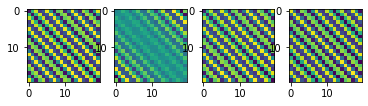

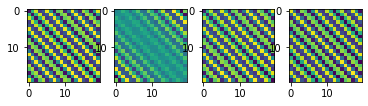

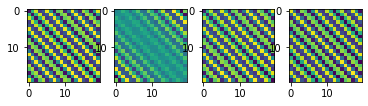

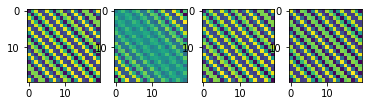

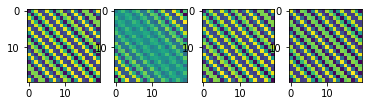

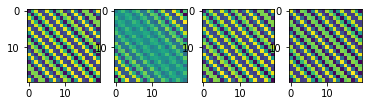

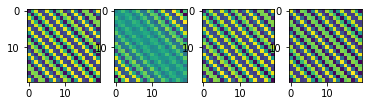

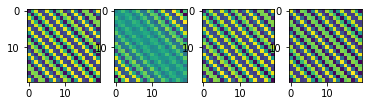

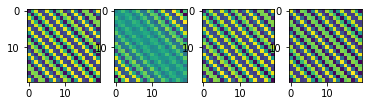

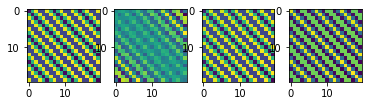

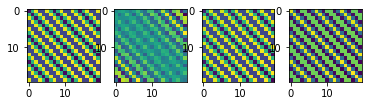

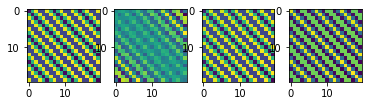

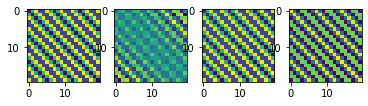

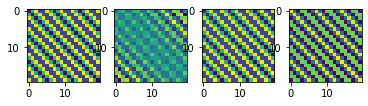

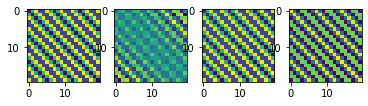

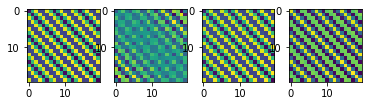

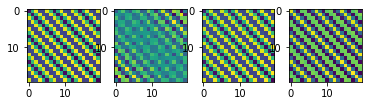

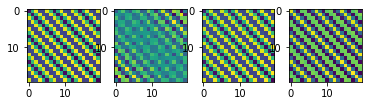

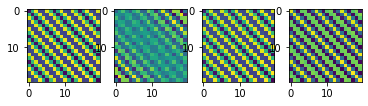

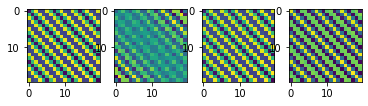

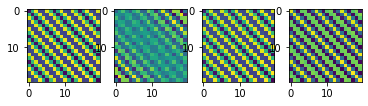

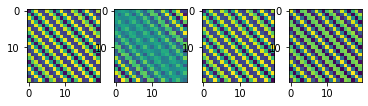

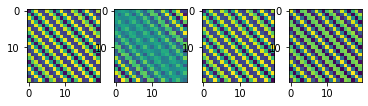

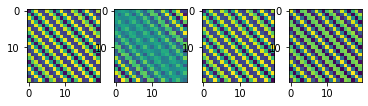

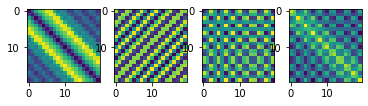

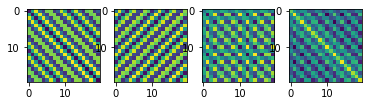

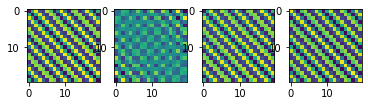

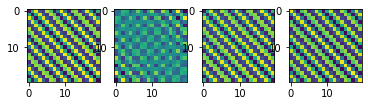

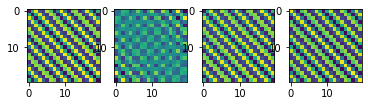

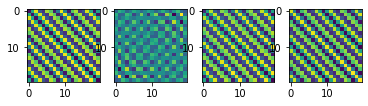

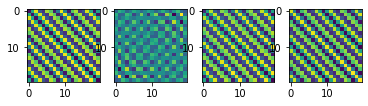

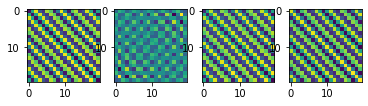

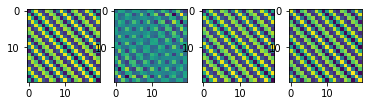

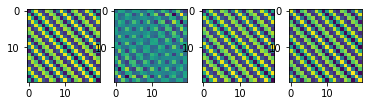

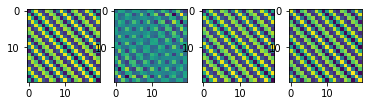

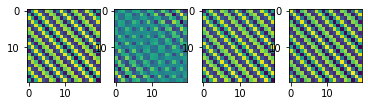

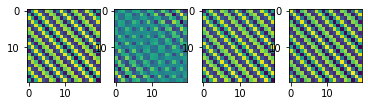

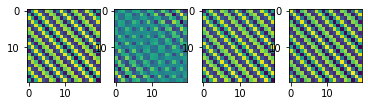

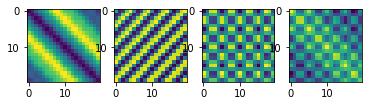

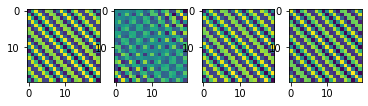

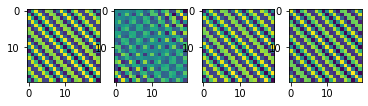

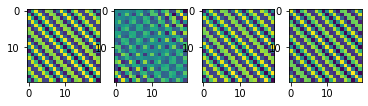

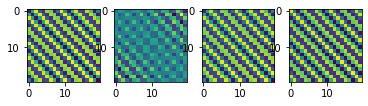

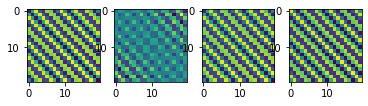

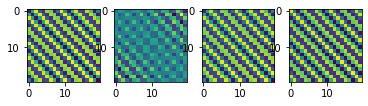

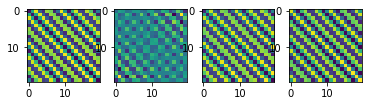

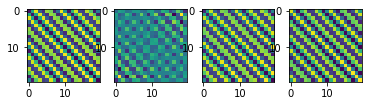

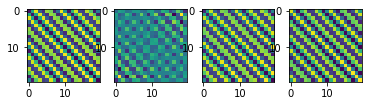

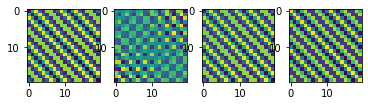

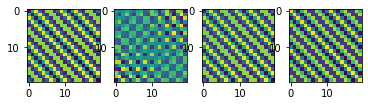

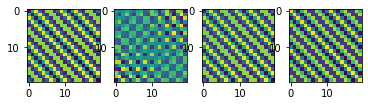

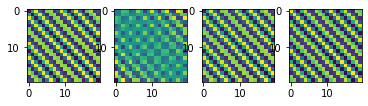

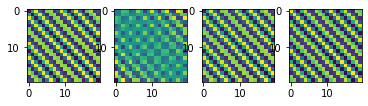

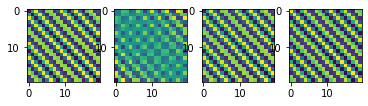

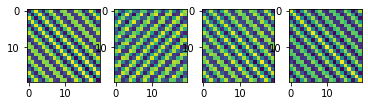

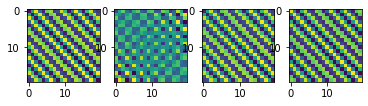

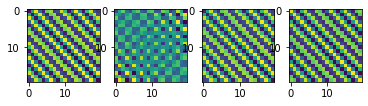

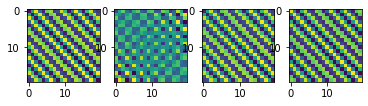

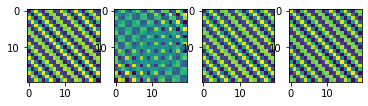

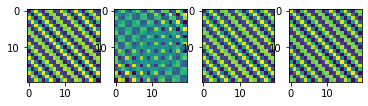

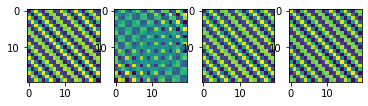

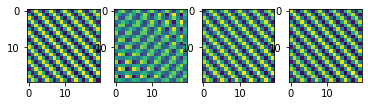

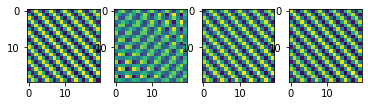

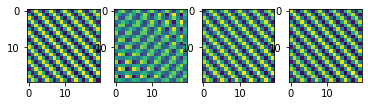

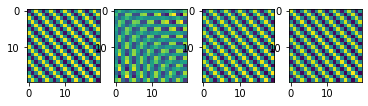

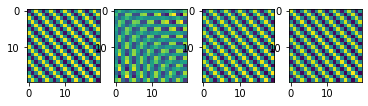

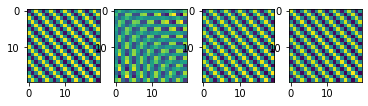

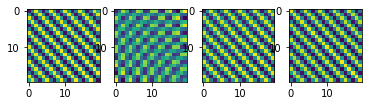

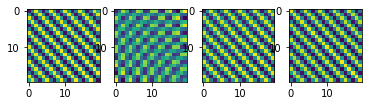

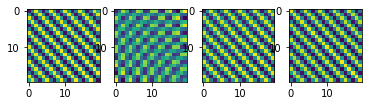

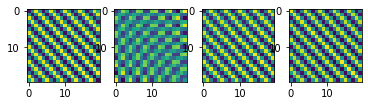

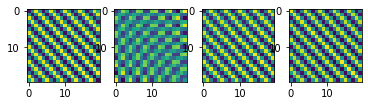

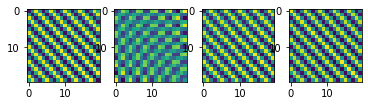

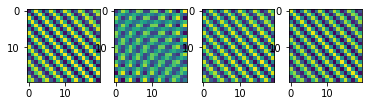

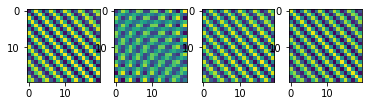

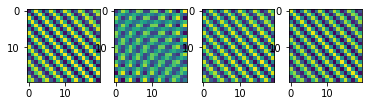

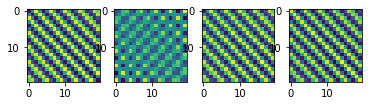

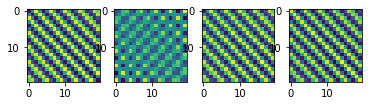

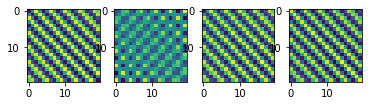

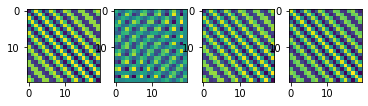

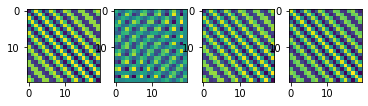

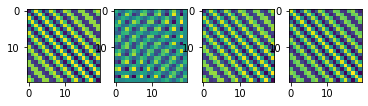

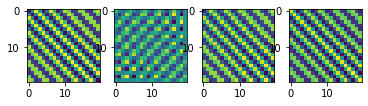

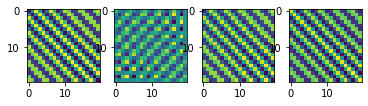

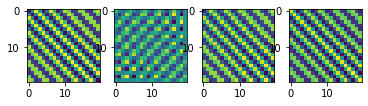

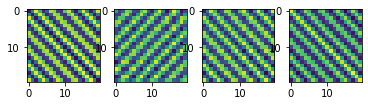

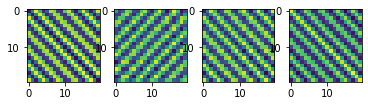

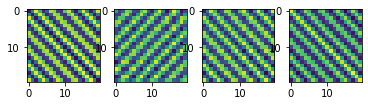

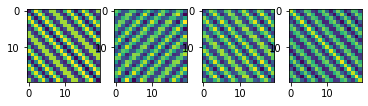

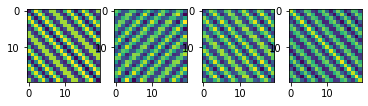

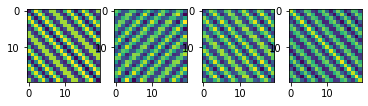

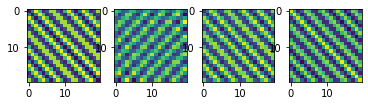

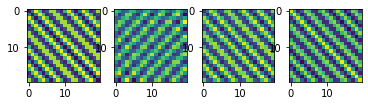

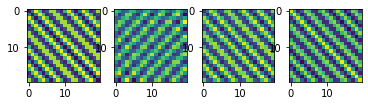

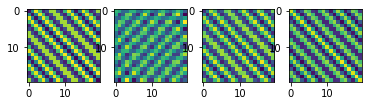

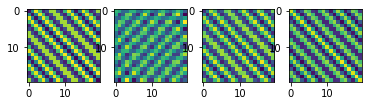

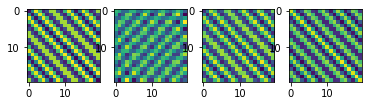

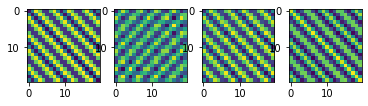

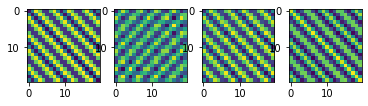

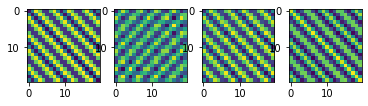

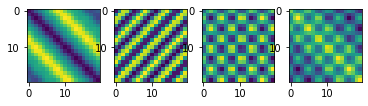

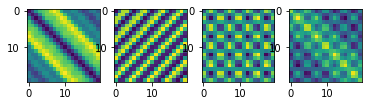

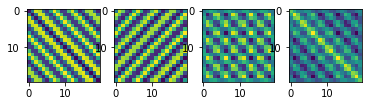

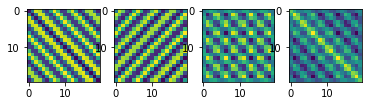

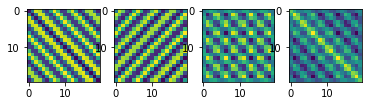

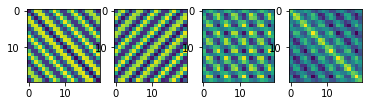

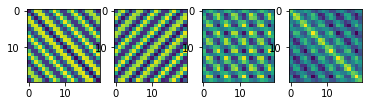

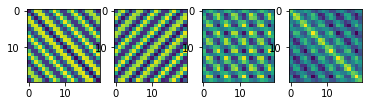

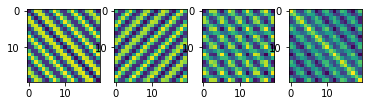

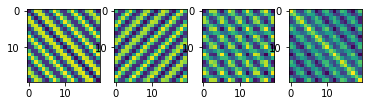

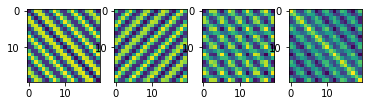

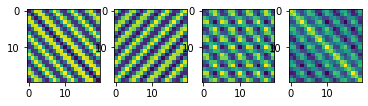

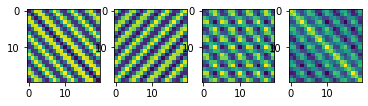

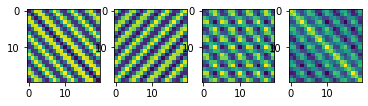

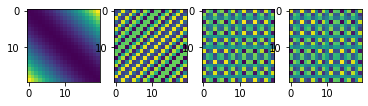

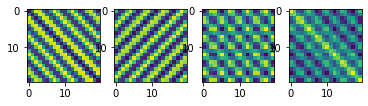

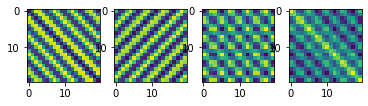

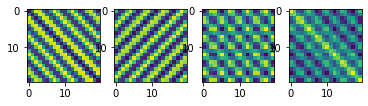

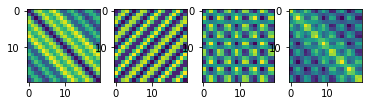

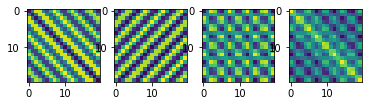

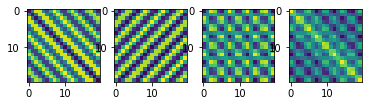

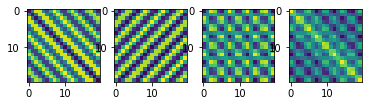

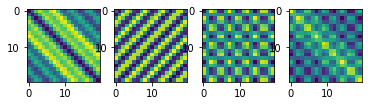

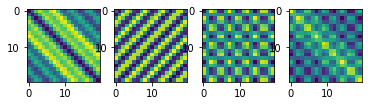

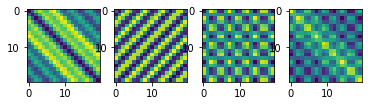

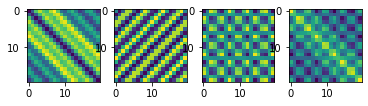

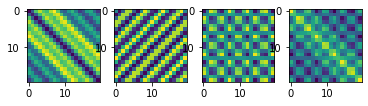

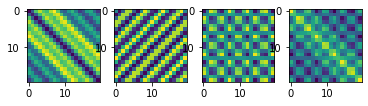

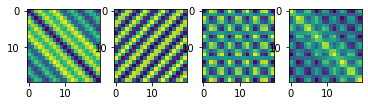

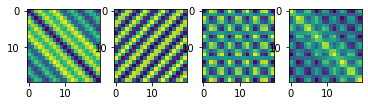

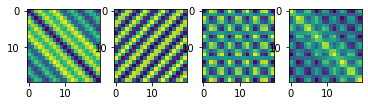

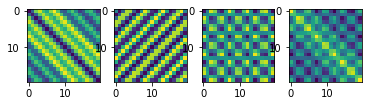

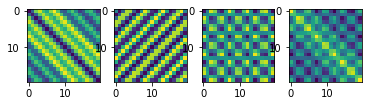

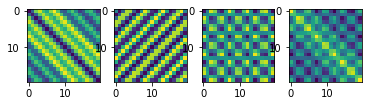

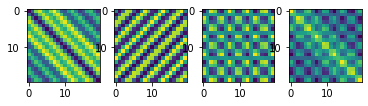

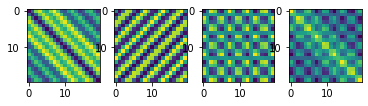

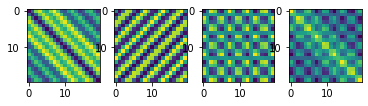

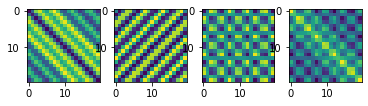

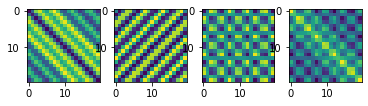

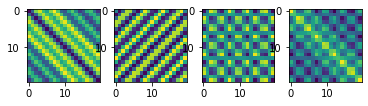

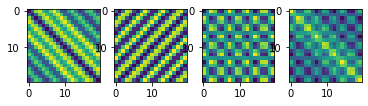

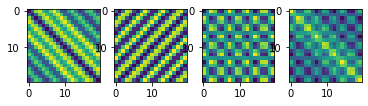

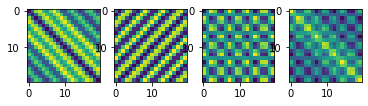

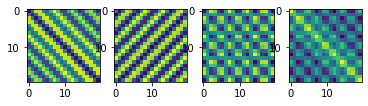

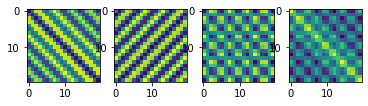

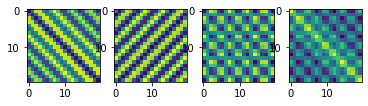

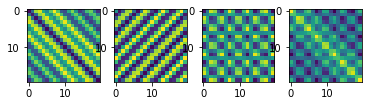

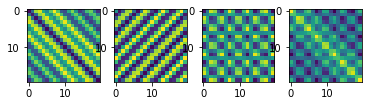

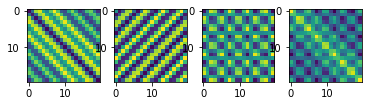

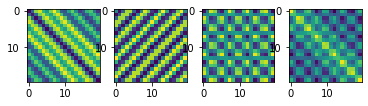

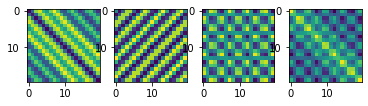

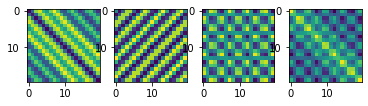

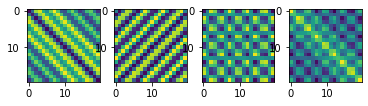

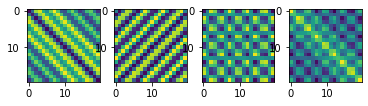

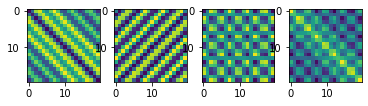

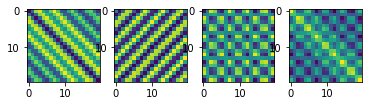

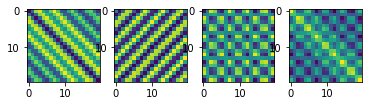

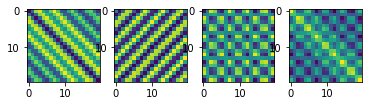

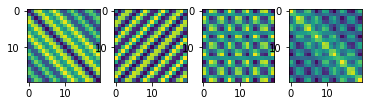

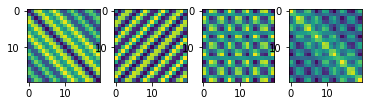

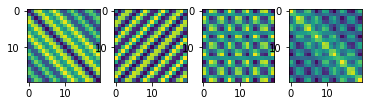

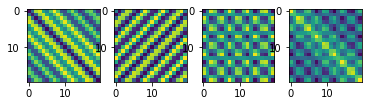

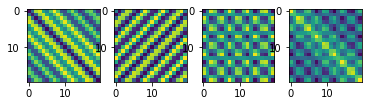

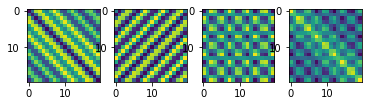

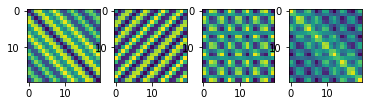

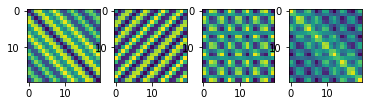

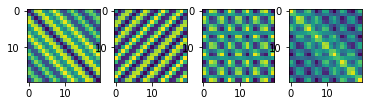

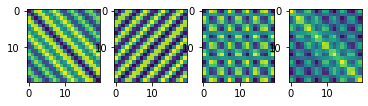

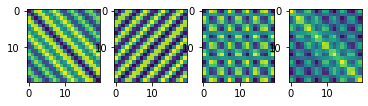

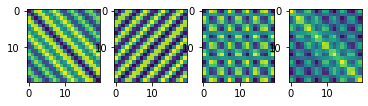

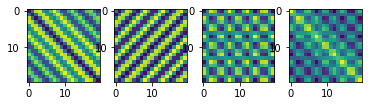

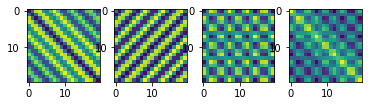

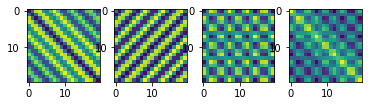

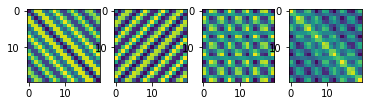

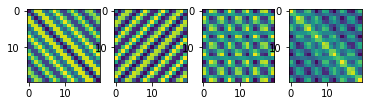

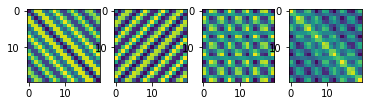

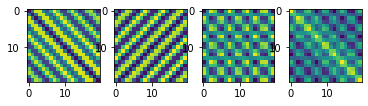

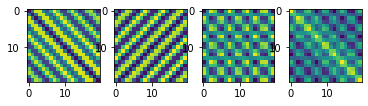

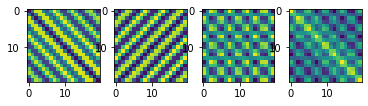

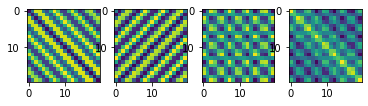

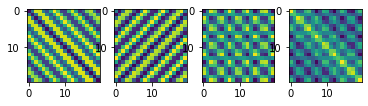

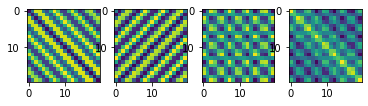

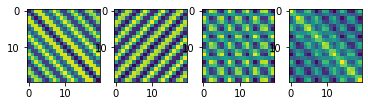

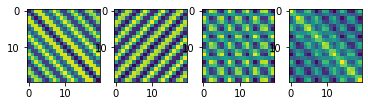

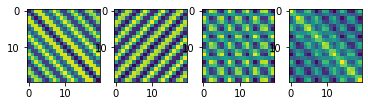

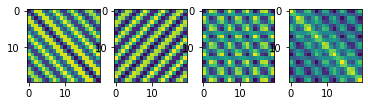

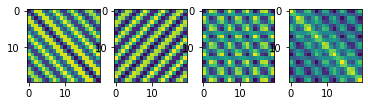

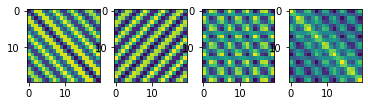

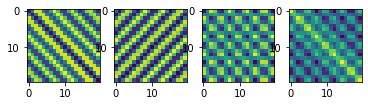

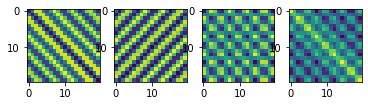

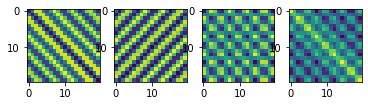

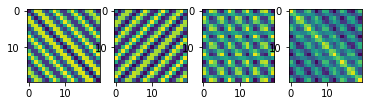

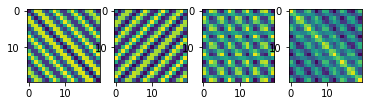

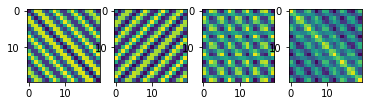

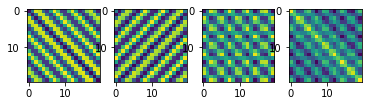

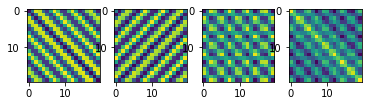

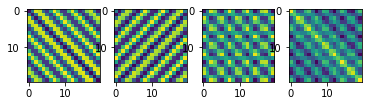

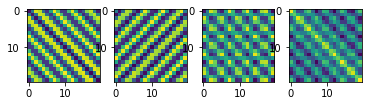

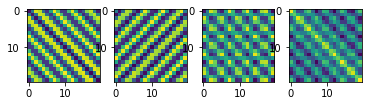

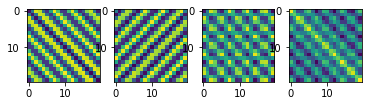

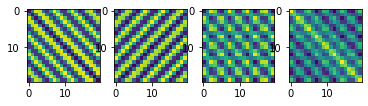

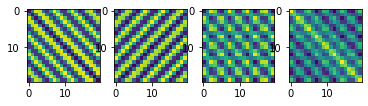

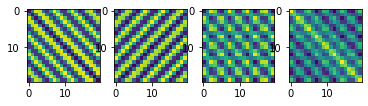

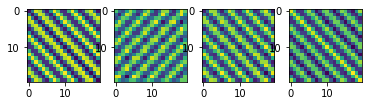

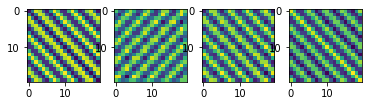

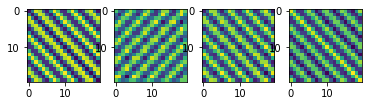

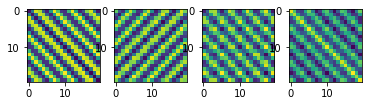

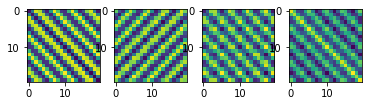

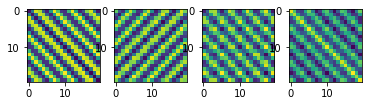

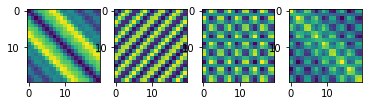

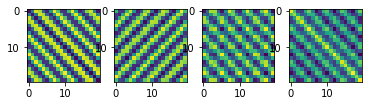

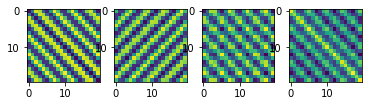

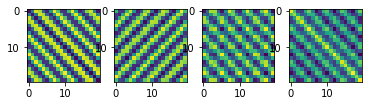

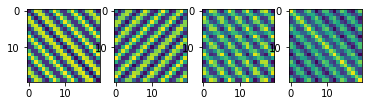

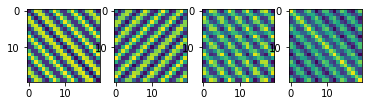

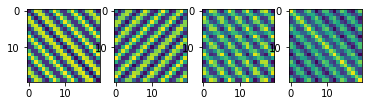

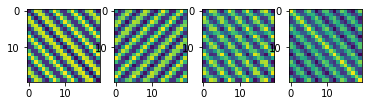

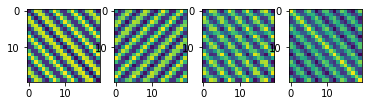

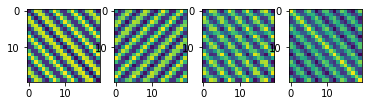

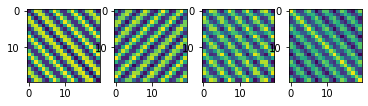

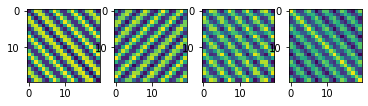

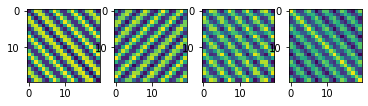

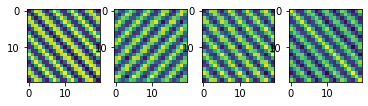

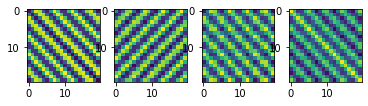

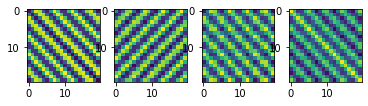

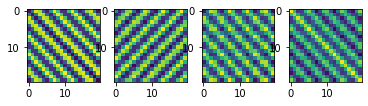

None


<Figure size 432x288 with 0 Axes>

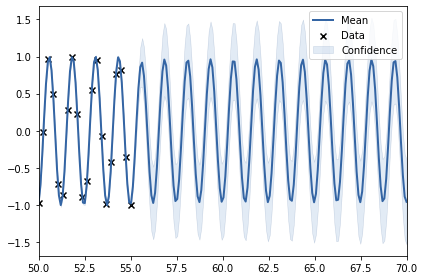

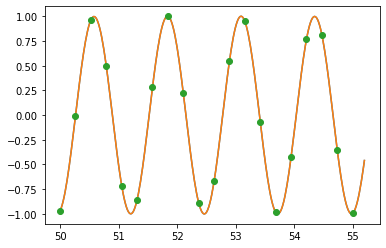

In [274]:
%matplotlib inline

noise = 1e-4
shift = +50
t1 = np.linspace(0,5, 20).reshape(-1,1) + shift
# create simple GP Model
# kernel_lfm1 = LFM2(input_dim=1,
#                  lengthscales=np.array([1]), bvec=np.array([10]), Cvec=np.array([0.3]),
#                  Smat=np.array([[1.0]]))

kernel_lfm1 = LFM2(input_dim=1,
                 lengthscales=np.array([1]), bvec=np.array([50]), Cvec=np.array([0.001]),
                 Smat=np.array([[1.0]]), debug=True)


y1 = np.sin(5*t1)



# m = GPy.core.gp.GP(t1*3, np.exp(-t1*3), kernel=kernel_lfm1, likelihood=likelihood)
print("why")
m = GPy.models.GPRegression(t1, y1 , kernel=kernel_lfm1, noise_var=noise)
print("regression")

m.kern.lengthscales.constrain_positive() 
m.kern.Cvec.constrain_positive() 
m.kern.Smat.constrain_positive() 
m.likelihood.variance.fix()

m.plot(plot_limits=(0 + shift, 8 + shift))
plt.show()
# # set the lengthscale to be something sensible (defaults to 1)
# m.kern.lengthscale = 10.

optimize = True
plot = True
if optimize:
    m.optimize('scg', max_iters=100, messages=True)
if plot:
    print(m.normalizer)
#     m.normalizer = False
    plt.show()
    plt.figure()
    tdem =  np.linspace(0  , 10  , 300).reshape(-1,1) + shift
    
    m.plot(plot_limits=(0 + shift, 20 + shift))
#     plt.plot(tdem,  np.sin(5*tdem))
    
    
    tcomp = np.linspace(0,3, 100).reshape(-1,1) + shift
    
    plt.show()
    tstar =  np.linspace(0 ,5.2 , 300).reshape(-1,1) + shift

    k_train =  m.kern.K(t1,t1)
    I = m.likelihood.variance * np.eye(k_train.shape[0])
    k_test = m.kern.K(tstar,t1)

    W = k_test.dot(np.linalg.inv(k_train + I ))

    mu = W.dot(y1)
    plt.show()
    plt.plot(tstar, m.predict(tstar, full_cov=True)[0])
    plt.plot(tstar, mu)
    plt.plot(t1, y1, 'o')
#     (X, X2, self.lengthscales.values, self.bvec.values, np.array([1]), self.Cvec.values, self.Smat.values)
#     dbe =  (vec_k_q_test(X, X2, self.lengthscales.values, self.bvec.values, np.array([1]), self.Cvec.values, self.Smat.values)  -  vec_k_q_test(X, X2, self.lengthscales.values, self.bvec.values, np.array([1]), self.Cvec.values, self.Smat.values) ) / 0.0001

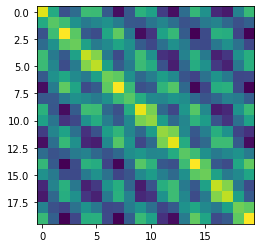

In [2355]:
plt.imshow(m.kern.K(t1,t1))

In [2031]:
if plot:
    print(m.normalizer)
#     m.normalizer = False
    plt.show()
    plt.figure()
    
#     m.plot(plot_limits=(0 + shift, 6.5 + shift))
    print("postplot")
    tcomp = np.linspace(0,3, 100).reshape(-1,1) + shift
    
    plt.show()
    tstar =  np.linspace(0,5.2, 300).reshape(-1,1) + shift

    k_train =  m.kern.K(t1,t1)
    I = noise* np.eye(k_train.shape[0])
    k_test = m.kern.K(tstar,t1)

    W = k_test.dot(np.linalg.inv(k_train + I ))

    mu = W.dot(y1)
    plt.show()
    plt.plot(tstar, m.predict(tstar, full_cov=True)[0])
    plt.plot(tstar, mu)
    plt.plot(t1, y1, 'o')

None
yournose


<Figure size 432x288 with 0 Axes>

 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning:invalid value encountered in true_divide


In [2017]:
np.linalg.eigh(k_train)[0].min()

8.193205293150909e-08

In [1755]:
np.linalg.matrix_rank(k_train + I)

20

In [1610]:
ks = 0.5 * (k_train + k_train.T)
keksimus = k_train + I
np.linalg.eigh(keksimus)[0]

array([-3.35853286e-03,  1.00000000e-02,  1.00000000e-02,  1.00000000e-02,
        1.00000000e-02,  1.00000001e-02,  1.00000014e-02,  1.00000121e-02,
        1.00000882e-02,  1.00005750e-02,  1.00034202e-02,  1.00189763e-02,
        1.01007531e-02,  1.05296697e-02,  1.29066865e-02,  2.75491488e-02,
        1.20803197e-01,  7.24208061e-01,  3.88058571e+00,  7.58487057e+00])

In [1609]:
np.diag(keksimus)

array([0.01      , 0.02527453, 0.1079558 , 0.2643695 , 0.45753652,
       0.63985712, 0.7769504 , 0.85597843, 0.88218047, 0.87072174,
       0.83907265, 0.80205138, 0.76962297, 0.74672838, 0.73428416,
       0.7306329 , 0.73294482, 0.73829305, 0.74430939, 0.74945413])

In [1585]:
k_train.shape

(20, 20)

In [1586]:
np.linalg.eigh(0.5*(k_train + k_train.T) )[0]

array([-1.33585329e-02, -3.09593497e-16,  1.89859775e-14,  6.28147609e-13,
        1.12256128e-11,  1.42497599e-10,  1.43191897e-09,  1.20556417e-08,
        8.81652205e-08,  5.74994719e-07,  3.42022211e-06,  1.89762869e-05,
        1.00753113e-04,  5.29669665e-04,  2.90668651e-03,  1.75491488e-02,
        1.10803197e-01,  7.14208061e-01,  3.87058571e+00,  7.57487057e+00])

In [1587]:
np.abs(k_train - k_train.T).max()

2.220446049250313e-16

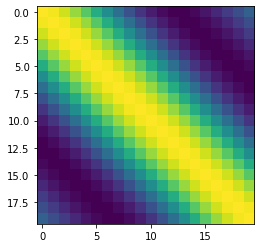

In [1629]:
plt.imshow(k_train)

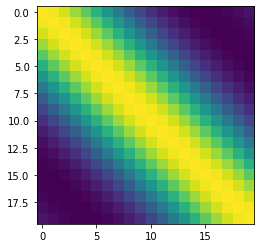

In [1589]:
plt.imshow(m.kern.K(t1 +50,t1+50))

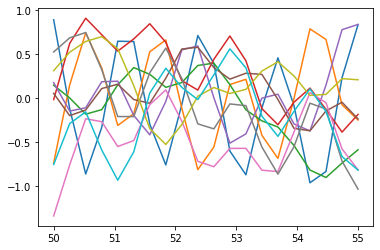

In [2354]:
ktrain= m.kern.K(t1 ,t1)
guys = np.random.multivariate_normal(np.zeros(ktrain.shape[0]), ktrain, 10)
guys.shape
[plt.plot(t1, guy) for guy in guys];

### Trying to use GPys multiout Framework

In [685]:

def k_f_m(tmat1, tmat2, l_vec, bvec, cvec, m, Smat, debug=False, d1s=None, d2s=None):
    q = l_vec.shape[0]
    
    n1 = tmat1[list(tmat1.keys())[0]].shape[0]
    n2 = tmat2[list(tmat2.keys())[0]].shape[0]
    
    if d1s is None:
        d1s = range(d)
    if d2s is None:
        d2s = range(d)
        
    d1_ = len(d1s)
    d2_ = len(d2s)
    
    kf = np.zeros((n1 * d1_, n2 * d2_), dtype=np.complex)
    
    for i_q in range(q):
        l_iq = l_vec[i_q]
        out =  None
        for d1 in d1s:
            for d2 in d2s:
                t1vec = tmat1[d1]
                t2vec = tmat2[d2]
                
                lq = l_vec[i_q]
                
                Bd1 = bvec[d1]
                Cd1 = cvec[d1]
                Sqd1 = Smat[i_q, d1]
                
                Bd2 = bvec[d2]
                Cd2 = cvec[d2]
                Sqd2 = Smat[i_q, d2]             
                
                cake = Sqd1 * Sqd2 * k_q(t1vec, t2vec, l_iq, Bd1, Cd1, m, Sqd1, Bd2, Cd2, m, Sqd2 , h_q=vec_h_q) 
                if out is None:
                    out = cake[None, ...]
                else:
                    out = np.concatenate((out, cake[None,...] ), axis=0)

        out = out.reshape(d1_, d2_, n1, n2)    
        out = np.transpose(out, (0,2,1,3)).reshape(n1 *d1_ , n2 * d2_)
        kf += out

    return np.real(kf)


class LFM2M(GPy.kern.Kern):
    
    def __init__(self,input_dim, bvec=np.array([1.0]),
                 lengthscales=np.array([1.0]),
                 Cvec=np.array([1.0]),
                 Smat=np.array([[1.0]]),
                 active_dims=(0,1), debug=False, quick_start=False):
    
        super(LFM2M, self).__init__(input_dim, active_dims, 'LFM2M')
        
#         assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.d = bvec.shape[0]
        self.q = lengthscales.shape[0]
        self.bvec = Param('bvec', bvec)
        self.lengthscales = Param('lengthscales', lengthscales)
        self.Smat = Param('Smat', Smat)
        self.Cvec = Param('Cvec', Cvec)
        self.link_parameters(self.bvec, self.lengthscales, self.Smat, self.Cvec)
        self.show = False
        self.debug = debug
        self.quick_start = quick_start
    
    def K(self,X,X2):
#         print(X)
#         print(X2)
        if X2 is None: X2 = X
#         import pdb; pdb.set_trace()
        d1s = np.unique(X[:,1]).astype(int)
        d2s = np.unique(X2[:,1]).astype(int)
        
        X_ = {} #np.zeros((X.shape[0], d1s.shape[0]))
        X2_ = {} # np.zeros((X2.shape[0], d2s.shape[0]))
        
        for d1 in d1s:
            X_[d1] =  X[X[:,1] == d1][:,0] 
        
        for d2 in d2s:
            X2_[d2] =  X2[X2[:,1] == d2][:,0]
            
        Bd1 = self.bvec
        Cd1 = self.Cvec
        Sqd1 = self.Smat
        lq = self.lengthscales
        k = k_f_m(X_, X2_, lq, Bd1, Cd1, 1.0, Sqd1, d1s=d1s, d2s=d2s)

        return np.real(k)
    
    def Kdiag(self, X):
        Bd1 = self.bvec[0]
        Cd1 = self.Cvec[0]
        Sqd1 = self.Smat[0,0]
        lq = self.lengthscales[0]
        return np.diag(self.K(X,X))
    
    def update_gradients_full(self, dL_dK, X, X2):
        if self.quick_start : return None
        if X2 is None: X2 = X
            
        d1s = np.unique(X[:,1]).astype(int)
        d2s = np.unique(X2[:,1]).astype(int)
        
        X_ = {} #np.zeros((X.shape[0], d1s.shape[0]))
        X2_ = {} # np.zeros((X2.shape[0], d2s.shape[0]))
        
        for d1 in d1s:
            X_[d1] =  X[X[:,1] == d1][:,0] 
        
        for d2 in d2s:
            X2_[d2] =  X2[X2[:,1] == d2][:,0]
#         import pdb; pdb.set_trace
        # (1, 10, 0.001, 1, 1)
#         print(self.lengthscales.values, self.bvec.values, self.Cvec.values, np.array([1.0]), self.Smat.values)
        gradients = grad_kf(X_, X2_, self.lengthscales.values, self.bvec.values, 
                             self.Cvec.values, np.array([1.0]), self.Smat.values, debug=False, func=k_f_m)
        
        
        dl = gradients[0]
        db = gradients[1]
        dC = gradients[2]
        dS = gradients[4]
        
        if self.debug:
            fig, axs= plt.subplots(2,4)
            axs[0,0].imshow(np.squeeze(dl[:,:,0]))
            axs[0,1].imshow(np.squeeze(db[:,:,0]))
            axs[0,2].imshow(np.squeeze(dC[:,:,0]))
            axs[0,3].imshow(np.squeeze(dS[:,:,0,0]))
            
            axs[1,0].imshow(np.squeeze(dl[:,:,0]))
            axs[1,1].imshow(np.squeeze(db[:,:,1]))
            axs[1,2].imshow(np.squeeze(dC[:,:,1]))
            axs[1,3].imshow(np.squeeze(dS[:,:,0,1]))

            plt.show()
#             s1 = int(0.5 * X.shape[0])
#             plt.imshow(db[s1:,s1:,1])
#             plt.show()
#             import pdb; pdb.set_trace()
        

        self.bvec.gradient = np.sum(db * dL_dK[..., None], axis=(0,1))
        self.lengthscales.gradient =  np.sum(dl * dL_dK[..., None], axis=(0,1))
        self.Cvec.gradient =  np.sum(dC * dL_dK[..., None], axis=(0,1))
        self.Smat.gradient =  np.sum(dS * dL_dK[..., None, None], axis=(0,1))
        


debug_multioutput = True


if debug_multioutput:

    d = 2
    n = 20
    b = 2
    bvec_ = np.array([ 0.5, 5])
    cvec_ = np.array([c, 0.1])
    Smat_ = np.array([[1.2, 10 ]])
    lvec_ = np.array([l])
    
    kern = LFM2M(2, bvec=bvec_, lengthscales=lvec_, Cvec=cvec_, Smat=Smat_)
    
    

    t14 = np.linspace(0,5, n).repeat(d).reshape(n,d) + 20
    y = np.sin(t14)
    
    print(t14[:,0].shape, y[:,0].shape)
    t_,y_, output_index = GPy.util.multioutput.build_XY([t14[:,0,None], t14[:,1, None]],[y[:,0,None], y[:,1,None]])
    kk4 = kern.K(t_, t_)

(20,) (20,)


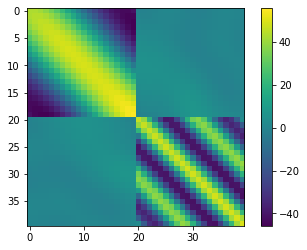

In [686]:
rescale = 1
kk4[20:, :20] *= rescale
kk4[:20, 20:] *= rescale
plt.imshow(kk4)
kk4[20:, :20] /= rescale
kk4[:20, 20:] /= rescale
plt.colorbar()

done init


 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning:invalid value encountered in true_divide


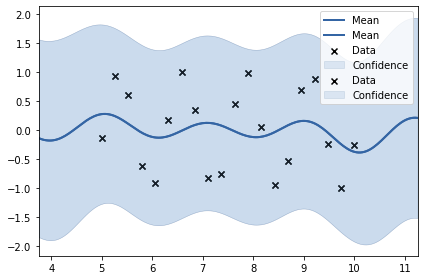

In [611]:
"""
A simple demonstration of coregionalization on two sinusoidal functions.
"""
noise = 1e-4
b = 10
c = 0.001 
s = 1
shift = 5

bvec_ = np.array([10, 10])
cvec_ = np.array([c, c])
Smat_ = np.array([[s, s  ]])
lvec_ = np.array([l])

kern = LFM2M(2, bvec=bvec_, lengthscales=lvec_, Cvec=cvec_, Smat=Smat_, debug=True, quick_start=True)

#build a design matrix with a column of integers indicating the output
X1 = np.linspace(0,5, 20) [..., None] + shift
X2 = np.linspace(0,5, 20)[...,None] + shift

#build a suitable set of observed variables
# Y1 = np.sin(X1) 
# Y2 = 2 * np.sin(5 * X2) 
Y1 = np.sin( 5 * X1) 
Y2 = np.sin(5 * X2) 

mco = GPy.models.GPCoregionalizedRegression(X_list=[X1,X2], Y_list=[Y1,Y2], kernel=kern)
mco.mixed_noise.Gaussian_noise_0.variance = noise
mco.mixed_noise.Gaussian_noise_1.variance = noise
print("done init")


optimize = True
plot = True
if optimize:
    try:
        mco.optimize('scg', max_iters=100, messages=True)
    except KeyboardInterrupt:
        pass

if plot:
    slices = GPy.util.multioutput.get_slices([X1,X2])
    mco.plot(fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0})
    mco.plot(fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1},ax=plt.gca())


In [606]:
mco.kern.Cvec

gp.LFM2M.Cvec:
Param([0.00546304, 0.00485377])

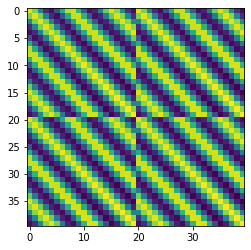

In [578]:
X,Y, output_index = GPy.util.multioutput.build_XY([X1, X2],[Y1, Y2])
plt.imshow(mco.kern.K(X, X))

In [409]:
ktrain =mco.kern.K(X, X)

[0. 1.] [0. 1.]


{'dataplot': [<matplotlib.collections.PathCollection at 0x2b2b4776c08>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2b2b477d908>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2b2b4797708>]}

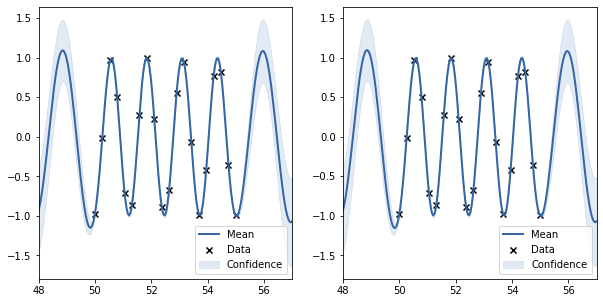

In [604]:
%matplotlib inline

# %matplotlib qt
# %matplotlib auto
slices = GPy.util.multioutput.get_slices([X1,X2])
fig, axs = plt.subplots(1,2, figsize=(10,5))
mco.plot(plot_limits=(shift -2, 7 +shift), fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0}, ax=axs[0])
mco.plot(plot_limits=(shift-2, 7 +shift), fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1},ax=axs[1])


{'dataplot': [<matplotlib.collections.PathCollection at 0x2b2b5c3f608>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2b2b5c43c88>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2b2b5c4ff88>]}

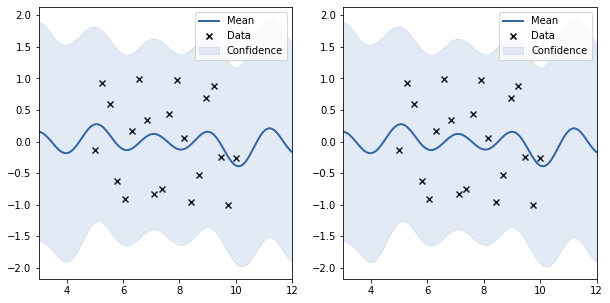

In [612]:
%matplotlib inline

# %matplotlib qt
# %matplotlib auto
slices = GPy.util.multioutput.get_slices([X1,X2])
fig, axs = plt.subplots(1,2, figsize=(10,5))
mco.plot(plot_limits=(shift -2, 7 +shift), fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0}, ax=axs[0])
mco.plot(plot_limits=(shift-2, 7 +shift), fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1},ax=axs[1])
